In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from committee_learning.ode import SquaredActivationODE
from committee_learning.initial_conditions import RandomNormalInitialConditions, SymmetricInitialConditions
from committee_learning.simulation import Simulation
from committee_learning.result import SquareODEResult, SimulationResult
import numpy as np
from tqdm import tqdm

d = 10000
p = 1
k = 1
alpha = 0.1
noise = 0.#1e-3
dt = 1e-4
log_time = 2
id_n = 56
ic_seed = 8

# The goal is to fix always the same initial conditions and then do many runs to see what happens

# # Just random
# ic = RandomNormalInitialConditions(p,k,d,spherical=True, seed=ic_seed)
# Wteacher, W0 = ic.Wteacher, ic.W0
# extra_string = ''

# Ortogonal
ic = SymmetricInitialConditions(p = p, k = k, epsilon=0., q0=1., seed = ic_seed)
Wteacher, W0 = ic.weights(d)
extra_string = '-orthogonal'

### Simulations

In [4]:
sim_times = []
sim_risks = []
for id in tqdm(range(id_n)):
  sim = Simulation(d,p,k,noise,Wteacher,alpha*p,'square',W0)
  # print(f'Simulating id = {id}')
  simr = SimulationResult(initial_condition=f'sde-test-browninian{extra_string}-icseed{ic_seed}', id=id)
  simr.from_file_or_run(sim,2+np.log10(sim.d),path='computation-database/sim/')
  if id == 0:
    sim_times = np.array(simr.steps)/d
  sim_risks.append(simr.macroscopic_risk())

sim_risks = np.array(sim_risks)

100%|██████████| 56/56 [00:16<00:00,  3.39it/s]


### ODE

In [5]:
ode = SquaredActivationODE(p,k,noise,alpha*p,ic.P,ic.Q,ic.M,dt)
oder = SquareODEResult(initial_condition=f'phase-retrivial-ode{extra_string}-icseed{ic_seed}', id=ic_seed)
oder.from_file_or_run(ode, log_time, path='computation-database/ode/')

### SDE

In [6]:
from committee_learning.sde.phase_retrivial import PhaseRetrivialSDE

sde_times = []
sde_risks = []

for id in tqdm(range(id_n)):
  sde = PhaseRetrivialSDE(noise, alpha*p, ic.P, ic.Q, ic.M, d, dt, seed=id)
  sder = SquareODEResult(initial_condition=f'sphase-retrivial-sde{extra_string}-icseed{ic_seed}', id=id)
  sder.from_file_or_run(sde, log_time, path='computation-database/sde/') #, force_run=True)
  if id == 0:
    sde_times = np.array(sder.times)
  sde_risks.append(sder.risks)

sde_risks = np.array(sde_risks)



100%|██████████| 56/56 [00:17<00:00,  3.25it/s]


Simulation exit time: 12.135535714285712
SDE exit time: 12.706528571428573


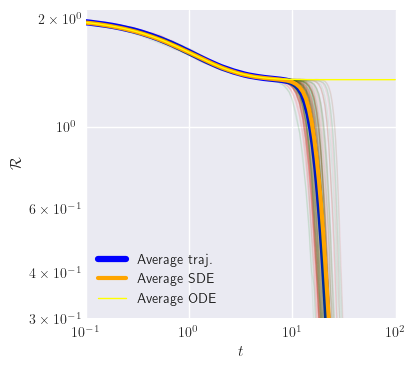

In [63]:
from committee_learning.utilities import plot_style
import matplotlib.pyplot as plt

def measure_exit_time(risks, threshold, times):
  et_index = np.argmin(risks > threshold, axis = -1)
  return times[et_index]

print(f'Simulation exit time: {np.mean(measure_exit_time(sim_risks, 1.32, sim_times))}')
print(f'SDE exit time: {np.mean(measure_exit_time(sde_risks, 1.32, sde_times))}')

with plot_style():
  fig, ax = plt.subplots(figsize=(4,4))
  ax.set_xlabel(r'$t$')
  ax.set_ylabel(r'$\mathcal{R}$')
  ax.set_xscale('log')
  ax.set_yscale('log')
  ax.set_xlim(.1,100)
  ax.set_ylim(3.e-1,2.1)
  ax.plot(sim_times, sim_risks.T,ls='-',lw=1.,marker='',ms=5.,c='red',alpha=0.075)
  ax.plot(sim_times, np.mean(sim_risks, axis = 0), label =f'Average traj.', ls='-',lw=4.5,marker='',ms=2.,c='blue')


  ax.plot(sde_times, sde_risks.T, ls='-',lw=1.,marker='',ms=2.,c='green', alpha=0.075)
  ax.plot(sde_times, np.mean(sde_risks, axis = 0), label =f'Average SDE', ls='-',lw=3.,marker='',c='orange')
  ax.plot(oder.times, oder.risks, label = 'Average ODE', ls='-',lw=1.,marker='',ms=1.5,c='yellow')
  ax.legend()
  plt.show()
  fig.savefig('figures/unconstrainted-sde-example.pdf', format = 'pdf', bbox_inches = 'tight')
  ax.set_xlim(1.,100)
  ax.set_ylim(1.3,1.42)
  T = ax.axhline(1.32, ls = ':', label = 'Threshold', lw=.7, c='black')
  t_sim = ax.axvline(np.mean(measure_exit_time(sim_risks, 1.32, sim_times)), ls = '-.', label = 'Sim. Exit time', lw=1,  c='red')
  t_sde = ax.axvline(np.mean(measure_exit_time(sde_risks, 1.32, sde_times)), ls = '-.', label = 'SDE Exit time', lw=1, c='green')
  ax.legend(handles=[T, t_sim, t_sde])
  fig.savefig('figures/unconstrainted-sde-example-zoom.pdf', format = 'pdf', bbox_inches = 'tight')

**Probably there is so much noise after the drop because we are entering in what Ben Arus calls "balistic phase", and the Brownian motion it's not there anymore.**

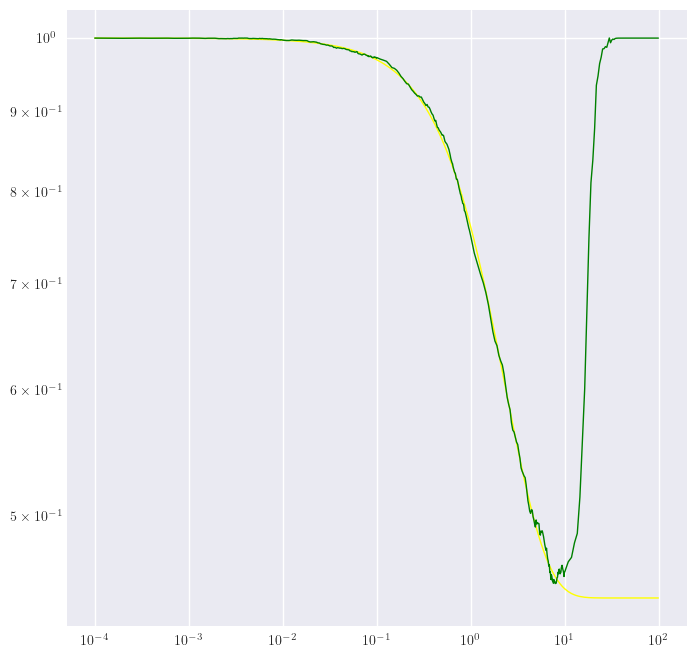

In [8]:
with plot_style():
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xscale('log')
  ax.set_yscale('log')
  # ax.set_xlim(1,100)
  # ax.set_ylim(.0001,1.6)

  ax.plot(oder.times, np.reshape(np.array(oder.Qs),(513,)), label = 'ODE', ls='-',lw=1.,marker='',ms=2.,c='yellow')
  ax.plot(oder.times, np.reshape(np.array(sder.Qs),(513,)), label = 'SDE', ls='-',lw=1.,marker='',ms=2.,c='green')
  plt.show()